# Descargar el Dataset de kaggle 
(No volver a descargar, ya está en la carpeta data/chestxray del proyecto)

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

100%|██████████| 42.0G/42.0G [05:58<00:00, 126MB/s] 

Extracting files...


Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


La celda de abajo mueve los archivos de la carpeta del cache de kagglehub a la carpeta del proyecto. 
En la instancia de Google Cloud los datos son persistentes, no es necesario bajarlos de GDrive.

In [9]:

from pathlib import Path
import shutil
from tqdm.notebook import tqdm

src = Path("/home/jupyter/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3")
dst = Path("./data/chestxray")

dst.mkdir(parents=True, exist_ok=True)

items = list(src.iterdir())
for p in tqdm(items, desc="Moviendo archivos"):
    target = dst / p.name
    try:
        # mover archivo o carpeta
        shutil.move(str(p), str(target))
    except Exception as e:
        print(f"Error moviendo {p}: {e}")


Moviendo archivos:   0%|          | 0/21 [00:00<?, ?it/s]

# imports necesarios y verificación de la carpeta con el dataset

In [1]:

from pathlib import Path
import sys
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


data_path = Path("./data/chestxray")


print("Data encontrada:", data_path.exists())

Data encontrada: True


# Preparación Entorno

Esta celda carga las clases de python locales

In [2]:
code_dir = (Path.cwd() / "code").resolve()
print("code_dir:", code_dir)
if not code_dir.exists():
    raise FileNotFoundError(f"No existe la carpeta {code_dir}")

if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))
    print("Añadido a sys.path")

# listar archivos relevantes
for p in sorted(code_dir.iterdir()):
    print("-", p.name)
from genCSVMap import prepare_labels_dataset

code_dir: /home/jupyter/ProyectoCNN/code
Añadido a sys.path
- .ipynb_checkpoints
- CNNTransformerFusion.py
- __pycache__
- datasetMgr.py
- genCSVMap.py


In [3]:
df = pd.read_csv(data_path / "Data_Entry_2017.csv")
print(df.head())

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [4]:
labels_df, train_val_df, test_df = prepare_labels_dataset(
    base_path='./data/chestxray'
)


labels train size: 86524  |  labels test size: 25596


One-hot encoding diseases: 100%|██████████| 14/14 [00:00<00:00, 28.47it/s]


Buscando imágenes en subcarpetas (extensiones png/jpg/jpeg) ...
112120 archivos de imágenes encontrados en la estructura de carpetas.


Resolviendo paths: 100%|██████████| 112120/112120 [00:05<00:00, 18917.67it/s]


Resolución: 112120 encontrados, 0 no encontrados.
0 entradas con múltiples candidatos (usa 'All_Paths' para ver opciones).
Dataset procesado guardado en: ./data/chestxray/IdxDataset.csv
Train/Val (marcados): 86524 imágenes
Test (marcados): 25596 imágenes
Total filas en processed_df (sin eliminar): 112120

Ejemplo (primeras 5 filas de processed_df):
        Image_Index                                               Path  \
0  00000001_000.png  data/chestxray/images_001/images/00000001_000.png   
1  00000001_001.png  data/chestxray/images_001/images/00000001_001.png   
2  00000001_002.png  data/chestxray/images_001/images/00000001_002.png   
3  00000002_000.png  data/chestxray/images_001/images/00000002_000.png   
4  00000003_000.png  data/chestxray/images_001/images/00000003_000.png   

                                           All_Paths  Num_Candidates  \
0  [data/chestxray/images_001/images/00000001_000...               1   
1  [data/chestxray/images_001/images/00000001_001...        

In [48]:
labels_df.columns

Index(['Image_Index', 'Path', 'All_Paths', 'Num_Candidates', 'Missing_Path',
       'Patient_Age', 'Gender_Code', 'View_Code', 'Atelectasis',
       'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
       'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'in_train_val', 'in_test'],
      dtype='object')

In [6]:

train_df, val_df = train_test_split( train_val_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)} imágenes")
print(f"Val:   {len(val_df)} imágenes")
print(f"Test:  {len(test_df)} imágenes")

Train: 69219 imágenes
Val:   17305 imágenes
Test:  25596 imágenes


# Transforming

In [7]:
DISEASE_COLUMNS = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAdjustSharpness(2, p=0.5),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [9]:
from datasetMgr import datasetMgr

In [10]:
train_dataset = datasetMgr(dataframe=train_df,disease_columns=DISEASE_COLUMNS,transform=train_transform)
val_dataset = datasetMgr(dataframe=val_df,disease_columns=DISEASE_COLUMNS,transform=val_transform)
test_dataset = datasetMgr(dataframe=test_df,disease_columns=DISEASE_COLUMNS,transform=val_transform)

In [11]:
print(f"Train dataset: {len(train_dataset)} muestras")
print(f"Val dataset:   {len(val_dataset)} muestras")
print(f"Test dataset:  {len(test_dataset)} muestras")


Train dataset: 69219 muestras
Val dataset:   17305 muestras
Test dataset:  25596 muestras


## Dataloader

In [27]:
BATCH_SIZE = 64
NUM_WORKERS = 7 #vCPU -1

In [28]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False,prefetch_factor=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False,prefetch_factor=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False,prefetch_factor=4)

### Dataloaders Creados

In [29]:
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")

   Train batches: 1082
   Val batches:   271
   Test batches:  400


In [30]:
images, meta, labels = next(iter(train_loader))

print(f"\nBatch de entrenamiento:")
print(f"Imágenes shape: {images.shape}")      # Debe ser (32, 3, 224, 224) para ser compatible por RESNET
print(f"Labels shape:   {labels.shape}")      # Debe ser (32, 14) IDEM
print(f"Imágenes - Min: {images.min():.3f}, Max: {images.max():.3f}")
print(f"Labels - Min:   {labels.min():.0f}, Max: {labels.max():.0f}")


print(f"\n  Labels por enfermedad en este batch:")
for i, disease in enumerate(DISEASE_COLUMNS):
    count = labels[:, i].sum().item()
    print(f"    {disease:20s}: {count:.0f}/{BATCH_SIZE}")


Batch de entrenamiento:
Imágenes shape: torch.Size([64, 3, 224, 224])
Labels shape:   torch.Size([64, 14])
Imágenes - Min: -2.118, Max: 2.640
Labels - Min:   0, Max: 1

  Labels por enfermedad en este batch:
    Atelectasis         : 7/64
    Consolidation       : 2/64
    Infiltration        : 7/64
    Pneumothorax        : 2/64
    Edema               : 2/64
    Emphysema           : 3/64
    Fibrosis            : 0/64
    Effusion            : 5/64
    Pneumonia           : 0/64
    Pleural_Thickening  : 0/64
    Cardiomegaly        : 0/64
    Nodule              : 2/64
    Mass                : 4/64
    Hernia              : 0/64



Visualizando imágenes de ejemplo...


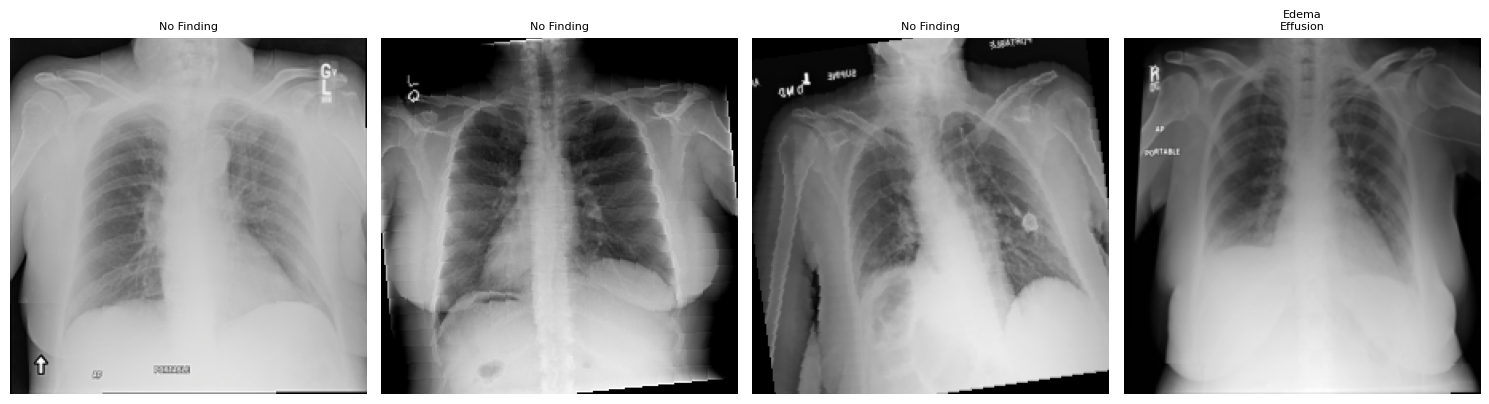

In [31]:

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def show_batch(images, labels, n=4):
    fig, axes = plt.subplots(1, n, figsize=(15, 4))

    for i in range(n):
        img = denormalize(images[i].cpu())
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        diseases = [DISEASE_COLUMNS[j] for j in range(14) if labels[i, j] == 1]
        diseases_str = '\n'.join(diseases[:3]) if diseases else 'No Finding'

        axes[i].imshow(img)
        axes[i].set_title(diseases_str, fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizando imágenes de ejemplo...")
show_batch(images, labels, n=4)

In [32]:
len(DISEASE_COLUMNS)

14

## Transfer Learning

In [33]:
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [35]:
num_classes = len(DISEASE_COLUMNS)

In [49]:
from sklearn.metrics import roc_curve
thresholds = []
for i in range(num_classes):
    y_true = all_labels[:, i]
    y_prob = 1 / (1 + np.exp(-all_outputs[:, i]))
    if np.sum(y_true) > 0:
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        j_scores = tpr - fpr
        best_t = thr[np.argmax(j_scores)]
        thresholds.append(best_t)
    else:
        thresholds.append(0.5)
print("Thresholds óptimos por clase:", np.round(thresholds, 3))


Thresholds óptimos por clase: [0.086 0.046 0.258 0.02  0.028 0.01  0.01  0.125 0.026 0.022 0.025 0.062
 0.035 0.001]


### DenseNet121

In [36]:
from CNNTransformerFusion import CNNTransformerFusion

Entrena los epochs hasta 100. En cada iteración corre un epoch de validación y toma el epoch con mejor val_mean_auc.
Si no mejora en 3 iteraciones, baja el learning rate en cada iteracion hasta la nro 8.
Cuando pasan 8 iteraciones sin mejoras deja de entrenar. 

In [38]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import time
import copy

num_epochs = 100                # valor alto inicial
patience = 8                    # early stopping patience
best_metric = -np.inf           # si monitorizas AUC (mayor es mejor); para val_loss usa +inf y criterio <

model = CNNTransformerFusion(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                       factor=0.5, patience=3)
# mode='max' porque vamos a monitorizar mean AUC (mayor mejor).

best_state = None
best_epoch = 0
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'val_mean_auc': []}

def compute_mean_auc(y_true, y_probs):
    aucs = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) > 0 and np.sum(y_true[:, i]) < len(y_true):  # requiere positivos y negativos
            aucs.append(roc_auc_score(y_true[:, i], y_probs[:, i]))
    if len(aucs) == 0:
        return np.nan
    return np.mean(aucs)

for epoch in range(1, num_epochs+1):
    t0 = time.time()
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    for images, meta, labels in train_loader:
        images, meta, labels = images.to(device, non_blocking=True), meta.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for images, meta, labels in val_loader:
            images, meta, labels = images.to(device), meta.to(device), labels.to(device)
            outputs = model(images, meta)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            all_outputs.append(outputs.cpu().sigmoid().numpy())   # convertir logits -> probs
            all_labels.append(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader.dataset)
    history['val_loss'].append(val_loss)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    val_mean_auc = compute_mean_auc(all_labels, all_outputs)
    history['val_mean_auc'].append(val_mean_auc if not np.isnan(val_mean_auc) else 0.0)

    # Scheduler (si usas ReduceLROnPlateau), usa la métrica que desees:
    # Aquí reducimos LR si val_mean_auc no mejora (mode='max' en scheduler)
    scheduler.step(val_mean_auc if not np.isnan(val_mean_auc) else 0.0)

    # ---- Early stopping & checkpoint (monitorizar val_mean_auc) ----
    is_best = (val_mean_auc is not np.nan) and (val_mean_auc > best_metric)
    if is_best:
        best_metric = val_mean_auc
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(best_state, "best_model.pth")
        print(f"Epoch {epoch}: ⭐ New best model (val_mean_auc={val_mean_auc:.4f}) saved.")
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch}/{num_epochs} - train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_mean_auc: {val_mean_auc:.4f}  time: {time.time()-t0:.1f}s")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered. No improvement in {patience} epochs.")
        break

print(f"Training finished. Best epoch: {best_epoch} with val_mean_auc={best_metric:.4f}")
# carga el mejor modelo
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1: ⭐ New best model (val_mean_auc=0.7311) saved.
Epoch 1/100 - train_loss: 0.1554  val_loss: 0.1472  val_mean_auc: 0.7311  time: 408.0s
Epoch 2: ⭐ New best model (val_mean_auc=0.7975) saved.
Epoch 2/100 - train_loss: 0.1403  val_loss: 0.1385  val_mean_auc: 0.7975  time: 407.3s
Epoch 3: ⭐ New best model (val_mean_auc=0.8193) saved.
Epoch 3/100 - train_loss: 0.1347  val_loss: 0.1354  val_mean_auc: 0.8193  time: 406.8s
Epoch 4: ⭐ New best model (val_mean_auc=0.8209) saved.
Epoch 4/100 - train_loss: 0.1315  val_loss: 0.1342  val_mean_auc: 0.8209  time: 415.4s
Epoch 5: ⭐ New best model (val_mean_auc=0.8326) saved.
Epoch 5/100 - train_loss: 0.1290  val_loss: 0.1327  val_mean_auc: 0.8326  time: 418.4s
Epoch 6: ⭐ New best model (val_mean_auc=0.8340) saved.
Epoch 6/100 - train_loss: 0.1266  val_loss: 0.1324  val_mean_auc: 0.8340  time: 412.3s
Epoch 7: ⭐ New best model (val_mean_auc=0.8341) saved.
Epoch 7/100 - train_loss: 0.1246  val_loss: 0.1328  val_mean_auc: 0.8341  time: 412.5s
Epoch 

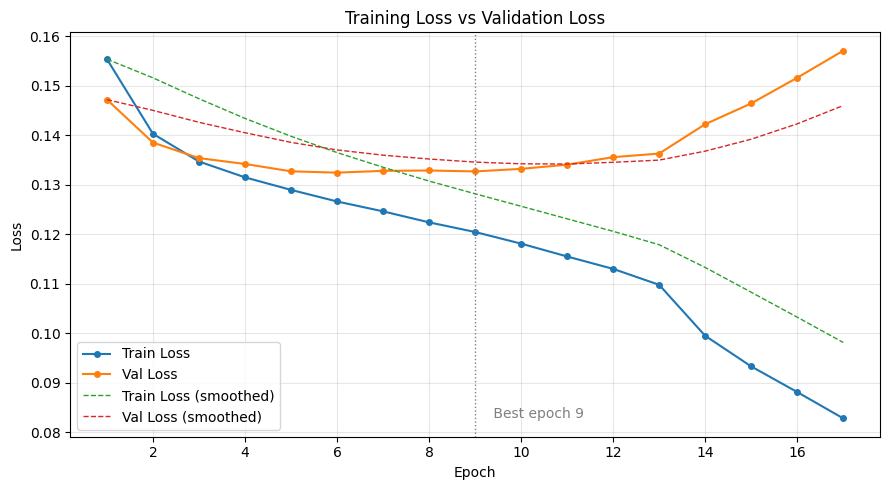

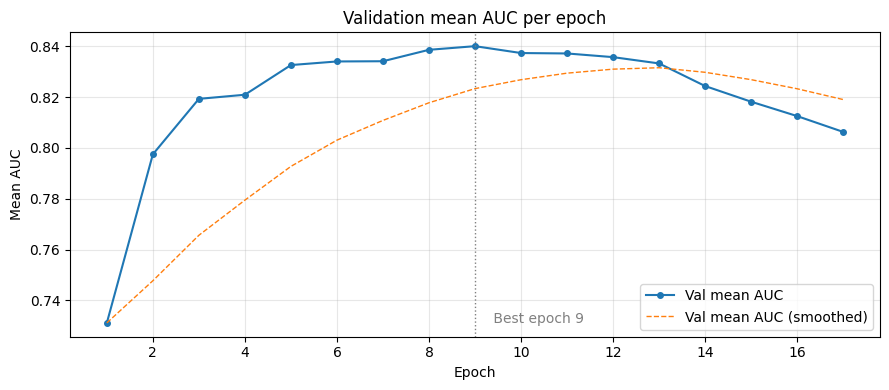

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer y convertir a numpy arrays (seguro contra listas)
train_losses = np.array(history['train_loss'], dtype=float)
val_losses = np.array(history['val_loss'], dtype=float)
val_mean_auc = np.array(history['val_mean_auc'], dtype=float)

epochs = np.arange(1, len(train_losses) + 1)

# ----- Función de suavizado (EMA) -----
def smooth(x, alpha=0.3):
    if len(x) == 0:
        return x
    out = [x[0]]
    for v in x[1:]:
        out.append(alpha * v + (1 - alpha) * out[-1])
    return np.array(out)

# ----- Plot Loss -----
plt.figure(figsize=(9,5))
plt.plot(epochs, train_losses, label='Train Loss', linewidth=1.5, marker='o', markersize=4)
plt.plot(epochs, val_losses, label='Val Loss', linewidth=1.5, marker='o', markersize=4)

# suavizado (opcional)
plt.plot(epochs, smooth(train_losses, alpha=0.25), label='Train Loss (smoothed)', linestyle='--', linewidth=1)
plt.plot(epochs, smooth(val_losses, alpha=0.25), label='Val Loss (smoothed)', linestyle='--', linewidth=1)

# marcar mejor epoch (si existe y está en rango)
if best_epoch and 1 <= best_epoch <= len(epochs):
    plt.axvline(best_epoch, color='gray', linestyle=':', linewidth=1)
    # calcular un y para la etiqueta de texto sin errores si todo es nan
    try:
        min_y = float(np.nanmin(np.concatenate([train_losses[~np.isnan(train_losses)], 
                                                val_losses[~np.isnan(val_losses)]])))
    except ValueError:
        # si todo es NaN (raro), usar 0
        min_y = 0.0
    plt.text(best_epoch + 0.3, min_y, f' Best epoch {best_epoch}', color='gray')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----- Plot Val Mean AUC (si quieres) -----
plt.figure(figsize=(9,4))
plt.plot(epochs, val_mean_auc, label='Val mean AUC', linewidth=1.5, marker='o', markersize=4)
plt.plot(epochs, smooth(val_mean_auc, alpha=0.25), label='Val mean AUC (smoothed)', linestyle='--', linewidth=1)

if best_epoch and 1 <= best_epoch <= len(epochs):
    plt.axvline(best_epoch, color='gray', linestyle=':', linewidth=1)
    # para la posición vertical del texto, elegir el mínimo finito
    finite_mask = np.isfinite(val_mean_auc)
    if finite_mask.any():
        y_text = float(np.nanmin(val_mean_auc[finite_mask]))
    else:
        y_text = 0.0
    plt.text(best_epoch + 0.3, y_text, f' Best epoch {best_epoch}', color='gray')

plt.xlabel('Epoch')
plt.ylabel('Mean AUC')
plt.title('Validation mean AUC per epoch')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Evaluacion DenseNet121

In [39]:
model.eval()
total_loss = 0.0
all_outputs = []
all_labels = []

with torch.no_grad():
    for images, meta, labels in tqdm(test_loader, desc="Evaluando"):
        images, meta, labels = images.to(device), meta.to(device), labels.to(device)
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        
        # Recopilar outputs y labels para AUC
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenar todos los outputs y labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Test Loss: {total_loss / len(test_loader.dataset):.4f}")

Evaluando: 100%|██████████| 400/400 [01:53<00:00,  3.52it/s]

Test Loss: 0.2084


#### Evaluación AUC

In [44]:
try:
    auc_scores = []
    for i in range(num_classes):
        if np.sum(all_labels[:, i]) > 0:
            # Aplicar sigmoid para convertir logits a probabilidades
            probs = 1 / (1 + np.exp(-all_outputs[:, i]))
            auc = roc_auc_score(all_labels[:, i], probs)
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)
    mean_auc = np.nanmean(auc_scores)
    print(f"\nAUC promedio: {mean_auc:.4f}")
    print("AUC por clase:", np.round(auc_scores, 3))
except Exception as e:
    print("Error al calcular AUC:", e)


AUC promedio: 0.7992
AUC por clase: [0.768 0.746 0.688 0.854 0.84  0.899 0.811 0.827 0.707 0.774 0.886 0.736
 0.813 0.84 ]


Saved confusion matrices figure to confusion_all_classes.png


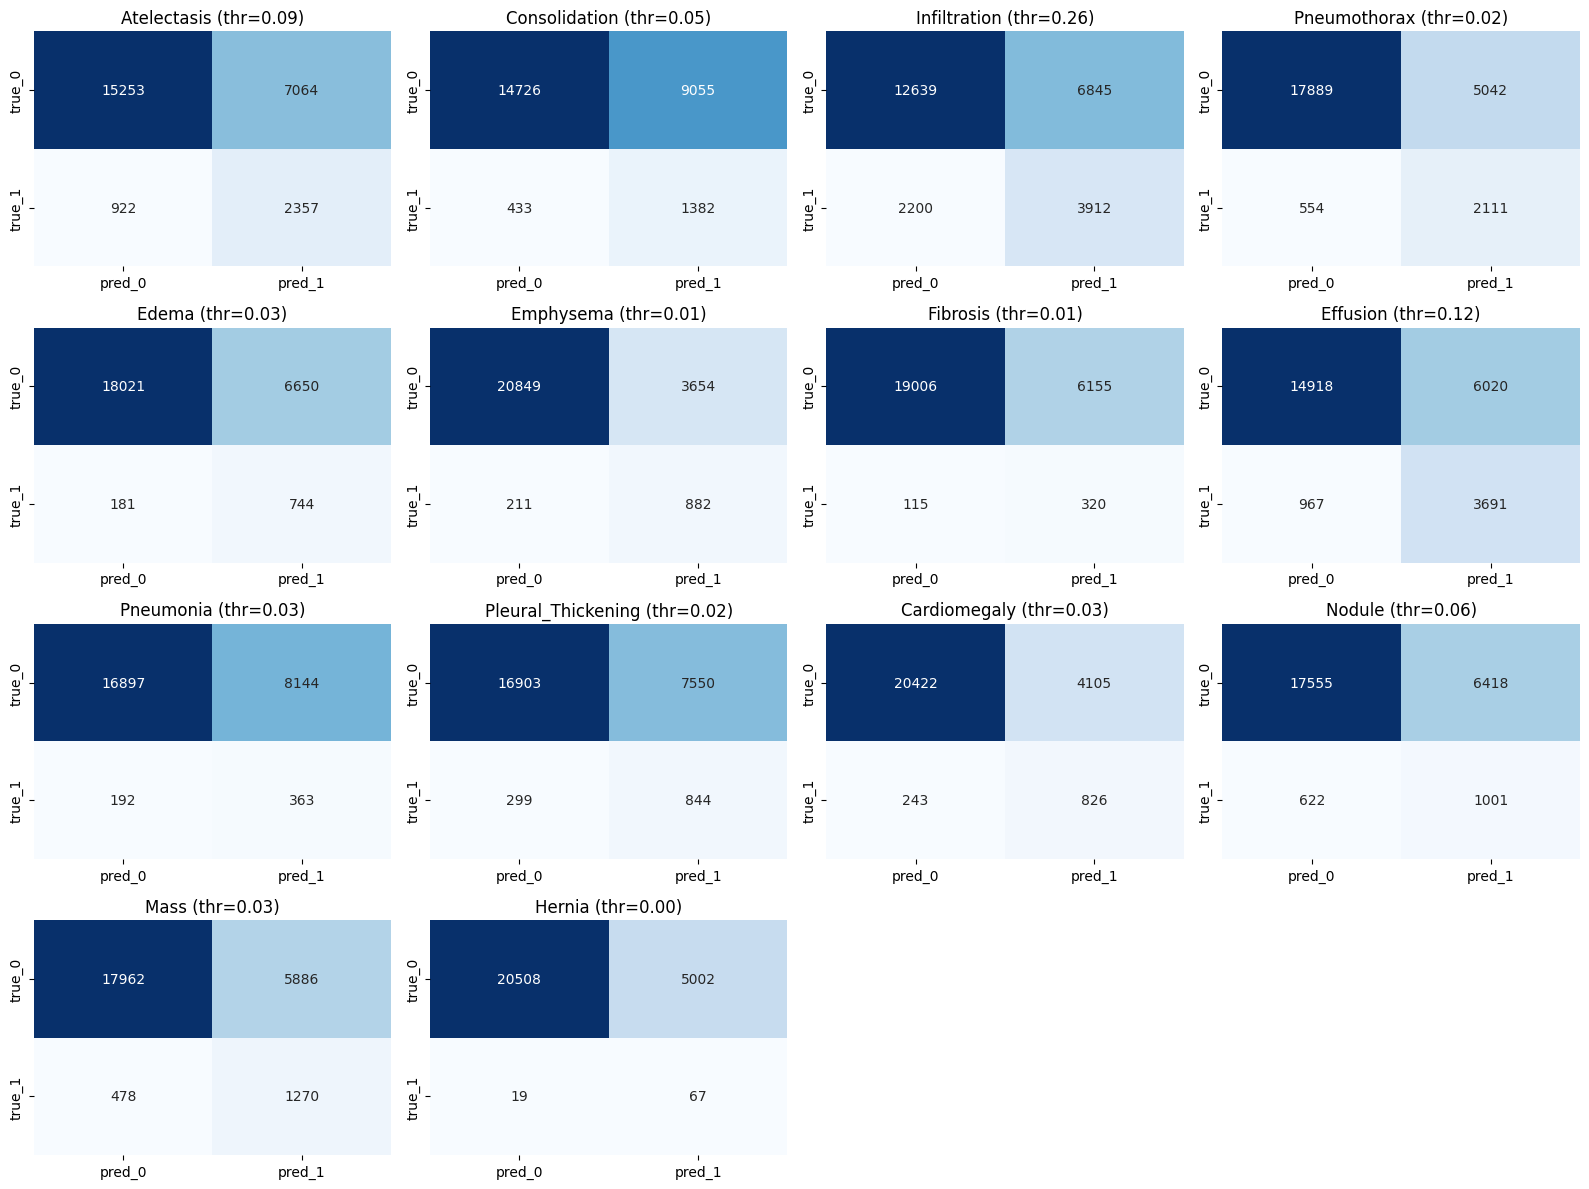

,class,threshold,TP,FP,FN,TN,accuracy,precision,recall,f1
0,Effusion,0.124977,3691,6020,967,14918,0.727028,0.380084,0.792400,0.513745
1,Infiltration,0.258012,3912,6845,2200,12639,0.646624,0.363670,0.640052,0.463809
2,Pneumothorax,0.019630,2111,5042,554,17889,0.781372,0.295121,0.792120,0.430026
3,Atelectasis,0.085779,2357,7064,922,15253,0.687998,0.250186,0.718817,0.371181
4,Emphysema,0.009622,882,3654,211,20849,0.849000,0.194444,0.806953,0.313377
5,Mass,0.034855,1270,5886,478,17962,0.751367,0.177473,0.726545,0.285265
6,Cardiomegaly,0.025181,826,4105,243,20422,0.830130,0.167512,0.772685,0.275333
7,Consolidation,0.045730,1382,9055,433,14726,0.629317,0.132414,0.761433,0.225596
8,Nodule,0.062279,1001,6418,622,17555,0.724957,0.134924,0.616759,0.221411
9,Edema,0.028152,744,6650,181,18021,0.733122,0.100622,0.804324,0.178868


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve

def get_optimal_threshold(y_true, y_probs):
    """Devuelve threshold que maximiza TPR - FPR (Youden index)."""
    try:
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)
        youden = tpr - fpr
        best_idx = np.nanargmax(youden)
        return thresholds[best_idx]
    except Exception:
        return 0.5

def plot_confusion_matrices(
    all_outputs,      # shape (N, num_classes) logits OR probs
    all_labels,       # shape (N, num_classes) 0/1
    class_names=None, # list of class names length=num_classes
    threshold=0.5,
    find_best_threshold=False,
    ncols=4,
    figsize_per_plot=(4,3),
    savepath=None
):
    """
    Dibuja una matriz de confusión por clase para problema multi-label.
    - all_outputs: logits OR probabilities. Si son logits, conviértelos a probs antes (sigmoid).
    - find_best_threshold: si True calcula threshold óptimo por clase (Youden).
    """
    # convert to numpy arrays
    probs = np.array(all_outputs, dtype=float)
    labels = np.array(all_labels, dtype=int)
    if probs.ndim != 2 or labels.ndim != 2:
        raise ValueError("all_outputs y all_labels deben ser arrays 2D (N x num_classes).")

    # Si son logits (valores fuera de [0,1]) aplica sigmoid
    if probs.min() < 0.0 or probs.max() > 1.0:
        probs = 1.0 / (1.0 + np.exp(-probs))  # sigmoid

    N, num_classes = probs.shape
    if class_names is None:
        class_names = [f"class_{i}" for i in range(num_classes)]
    assert len(class_names) == num_classes

    # thresholds por clase
    thresholds = np.full(num_classes, threshold, dtype=float)
    if find_best_threshold:
        for i in range(num_classes):
            # si no hay positivos/negativos suficiente, conservar 0.5
            if np.sum(labels[:, i]) > 0 and np.sum(labels[:, i]) < N:
                thresholds[i] = get_optimal_threshold(labels[:, i], probs[:, i])
            else:
                thresholds[i] = threshold

    # decisiones binarias por clase
    preds = (probs >= thresholds[np.newaxis, :]).astype(int)

    # Preparar grid de plots
    ncols = int(ncols)
    nrows = int(np.ceil(num_classes / ncols))
    fig_w = ncols * figsize_per_plot[0]
    fig_h = nrows * figsize_per_plot[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
    axes = axes.flatten() if num_classes > 1 else [axes]

    # Recolectar summary
    summary = []

    for i in range(num_classes):
        ax = axes[i]
        y_true = labels[:, i]
        y_pred = preds[:, i]

        # si no hay positivos ni negativos, saltear
        if np.sum(y_true) == 0:
            tn = fp = fn = tp = 0
            cm = np.array([[0, 0],[0, 0]])
        else:
            cm = confusion_matrix(y_true, y_pred, labels=[0,1])
            # confusion_matrix retorna [[tn, fp], [fn, tp]]
            tn, fp, fn, tp = cm.ravel()

        # métricas seguras (evitar division por 0)
        acc = accuracy_score(y_true, y_pred) if (np.sum(y_true) + np.sum(~y_true.astype(bool)) > 0) else np.nan
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        summary.append({
            "class": class_names[i],
            "threshold": float(thresholds[i]),
            "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
            "accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1)
        })

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                    xticklabels=["pred_0","pred_1"], yticklabels=["true_0","true_1"])
        ax.set_title(f"{class_names[i]} (thr={thresholds[i]:.2f})")
        ax.set_ylabel("")  # opcional
        ax.set_xlabel("")  # opcional

    # ocultar ejes sobrantes
    for j in range(num_classes, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
        print(f"Saved confusion matrices figure to {savepath}")
    plt.show()

    # imprimir resumen ordenado por f1 (u otra métrica)
    import pandas as pd
    df_sum = pd.DataFrame(summary)
    df_sum = df_sum.sort_values(by='f1', ascending=False).reset_index(drop=True)
    display(df_sum)
    return df_sum, preds, thresholds

# ---------------------------
# EJEMPLO de uso (ya tienes all_outputs y all_labels de tu evaluación):
# ---------------------------
# class_names: lista con nombres de las enfermedades (en el mismo orden que tus clases)
# Si quieres thresholds óptimos por clase:
class_names = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]
df_summary, preds, thresholds = plot_confusion_matrices(all_outputs, all_labels, class_names=class_names, find_best_threshold=True, ncols=4, savepath="confusion_all_classes.png")
#
# O usando threshold fijo 0.5:
# df_summary, preds, thresholds = plot_confusion_matrices(all_outputs, all_labels, class_names=class_names, threshold=0.5, find_best_threshold=False)


Thresholds por clase (usados):
 - Atelectasis: 0.086
 - Consolidation: 0.046
 - Infiltration: 0.258
 - Pneumothorax: 0.020
 - Edema: 0.028
 - Emphysema: 0.010
 - Fibrosis: 0.010
 - Effusion: 0.125
 - Pneumonia: 0.026
 - Pleural_Thickening: 0.022
 - Cardiomegaly: 0.025
 - Nodule: 0.062
 - Mass: 0.035
 - Hernia: 0.001

Resumen global de samples:
 - Total samples: 25596
 - Samples sin patología en GT (all zeros): 9861 (38.53%)
 - Samples donde modelo no predijo ninguna clase: 3191 (12.47%)
 - Entre imágenes enfermas, misses (no_pred & tiene GT>0): 738 (4.69%)


,class,threshold,TP,FP,FN,TN,positives_gt,precision,recall,f1,accuracy,miss_rate_pct
11,Nodule,0.062279,1001,6418,622,17555,1623,0.134924,0.616759,0.221411,0.724957,38.324091
2,Infiltration,0.258012,3912,6845,2200,12639,6112,0.363670,0.640052,0.463809,0.646624,35.994764
8,Pneumonia,0.026015,363,8144,192,16897,555,0.042671,0.654054,0.080115,0.674324,34.594595
0,Atelectasis,0.085779,2357,7064,922,15253,3279,0.250186,0.718817,0.371181,0.687998,28.118329
12,Mass,0.034855,1270,5886,478,17962,1748,0.177473,0.726545,0.285265,0.751367,27.345538
6,Fibrosis,0.009907,320,6155,115,19006,435,0.049421,0.735632,0.092619,0.755040,26.436782
9,Pleural_Thickening,0.022433,844,7550,299,16903,1143,0.100548,0.738408,0.176995,0.693351,26.159230
1,Consolidation,0.045730,1382,9055,433,14726,1815,0.132414,0.761433,0.225596,0.629317,23.856749
10,Cardiomegaly,0.025181,826,4105,243,20422,1069,0.167512,0.772685,0.275333,0.830130,22.731525
13,Hernia,0.001479,67,5002,19,20508,86,0.013218,0.779070,0.025994,0.803837,22.093023



Per-class summary saved to eval_outputs_per_class_summary.csv
Saved histograms to eval_outputs_prob_histograms.png


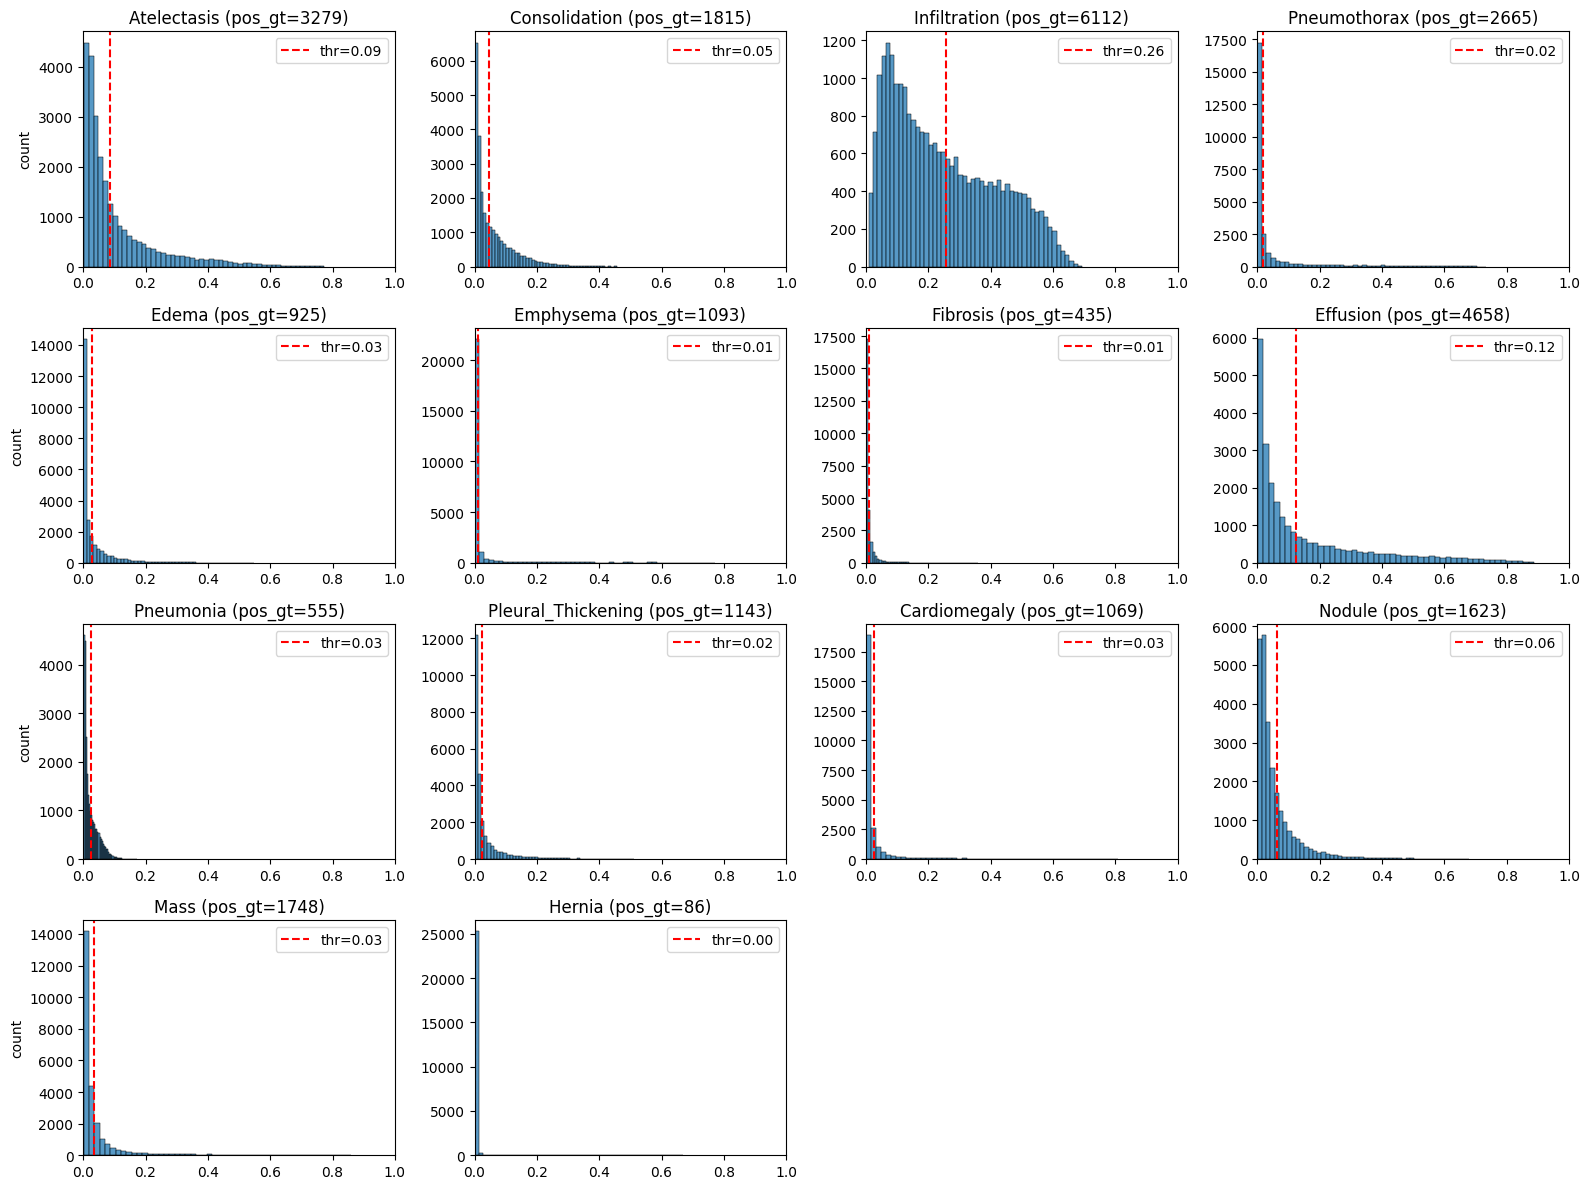


Ejemplos (hasta 20) de indices con GT>0 pero modelo no predijo nada (no_pred): 738 encontrados.
[  0  55  72  93 103 132 138 171 184 193 219 229 240 288 388 393 394 395
 412 417]
No tienes 'image_names' en memoria (opcional). Si las proporcionás, guardo un CSV con nombres e índices.


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# ---------------------------
# CONFIG (ajusta si querés)
# ---------------------------
USE_OPTIMAL_THRESHOLDS = True   # calcula thresholds por Youden; si False usa FIXED_THRESHOLD
FIXED_THRESHOLD = 0.5
PLOT_NCOLS = 4                  # columnas para grid de histogramas
FIGSIZE_PER_PLOT = (4,3)
SAVE_PLOTS = True
OUT_PREFIX = "eval_outputs"     # prefix para archivos guardados
# ---------------------------

# Asegurar arrays numpy
probs = np.array(all_outputs, dtype=float)   # puede ser logits o probs
labels = np.array(all_labels, dtype=int)     # 0/1

# Convertir logits->probs si hace falta (valores fuera [0,1])
if probs.min() < 0.0 or probs.max() > 1.0:
    probs = 1.0 / (1.0 + np.exp(-probs))

N, C = probs.shape
try:
    class_names
except NameError:
    class_names = [f"class_{i}" for i in range(C)]

# ---------------------------
# Calcular thresholds por clase (Youden / ROC) o usar fijo
# ---------------------------
thresholds = np.full(C, FIXED_THRESHOLD, dtype=float)
if USE_OPTIMAL_THRESHOLDS:
    for i in range(C):
        y_true = labels[:, i]
        y_prob = probs[:, i]
        if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):  # necesita positivos y negativos
            fpr, tpr, thr = roc_curve(y_true, y_prob)
            youden = tpr - fpr
            best_idx = np.nanargmax(youden)
            thresholds[i] = float(thr[best_idx])
        else:
            thresholds[i] = FIXED_THRESHOLD  # fallback

print("Thresholds por clase (usados):")
for i, t in enumerate(thresholds):
    print(f" - {class_names[i]}: {t:.3f}")

# ---------------------------
# Predicciones binarias usando thresholds por clase
# ---------------------------
preds = (probs >= thresholds[np.newaxis, :]).astype(int)

# ---------------------------
# Estadísticas por sample (global)
# ---------------------------
# muestras sin labels reales (normales)
no_true_mask = (labels.sum(axis=1) == 0)
num_no_true = int(no_true_mask.sum())
pct_no_true = num_no_true / N * 100.0

# muestras en las que modelo no predijo nada (todas 0)
no_pred_mask = (preds.sum(axis=1) == 0)
num_no_pred = int(no_pred_mask.sum())
pct_no_pred = num_no_pred / N * 100.0

# de las imágenes enfermas, cuántas quedaron sin predicción (miss rate)
gt_positive_mask = ~no_true_mask
miss_on_sick_mask = no_pred_mask & gt_positive_mask
num_miss_on_sick = int(miss_on_sick_mask.sum())
pct_miss_on_sick = (num_miss_on_sick / max(1, gt_positive_mask.sum())) * 100.0

print("\nResumen global de samples:")
print(f" - Total samples: {N}")
print(f" - Samples sin patología en GT (all zeros): {num_no_true} ({pct_no_true:.2f}%)")
print(f" - Samples donde modelo no predijo ninguna clase: {num_no_pred} ({pct_no_pred:.2f}%)")
print(f" - Entre imágenes enfermas, misses (no_pred & tiene GT>0): {num_miss_on_sick} ({pct_miss_on_sick:.2f}%)")

# ---------------------------
# Estadísticas por clase y confusion matrices
# ---------------------------
rows = []
for i in range(C):
    y_true = labels[:, i]
    y_pred = preds[:, i]
    # confusion matrix (tn, fp, fn, tp)
    if np.unique(y_true).size == 1:
        # si solo hay un tipo (todos 0 o todos 1), confusion_matrix puede comportarse raro
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))
    else:
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    # miss rate para esta clase: de los positivos reales, cuántos no predijimos
    pos_total = int(y_true.sum())
    miss_rate = (fn / pos_total) * 100.0 if pos_total > 0 else np.nan

    rows.append({
        "class": class_names[i],
        "threshold": float(thresholds[i]),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "positives_gt": pos_total,
        "precision": float(prec), "recall": float(rec), "f1": float(f1), "accuracy": float(acc),
        "miss_rate_pct": miss_rate
    })

per_class_summary = pd.DataFrame(rows).sort_values(by='miss_rate_pct', ascending=False)
display(per_class_summary)
per_class_summary.to_csv(f"{OUT_PREFIX}_per_class_summary.csv", index=False)
print(f"\nPer-class summary saved to {OUT_PREFIX}_per_class_summary.csv")

# ---------------------------
# Histogramas de probabilidades por clase
# ---------------------------
ncols = PLOT_NCOLS
nrows = int(np.ceil(C / ncols))
fig_w = ncols * FIGSIZE_PER_PLOT[0]
fig_h = nrows * FIGSIZE_PER_PLOT[1]
fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
axes = axes.flatten()

for i in range(C):
    ax = axes[i]
    sns.histplot(probs[:, i], bins=50, kde=False, stat='count', ax=ax)
    ax.axvline(thresholds[i], color='red', linestyle='--', label=f"thr={thresholds[i]:.2f}")
    ax.set_title(f"{class_names[i]} (pos_gt={int(labels[:,i].sum())})")
    ax.set_xlim(0,1)
    if i % ncols == 0:
        ax.set_ylabel("count")
    else:
        ax.set_ylabel("")
    ax.legend()

# ocultar ejes extras
for j in range(C, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
if SAVE_PLOTS:
    fname = f"{OUT_PREFIX}_prob_histograms.png"
    plt.savefig(fname, dpi=200, bbox_inches='tight')
    print(f"Saved histograms to {fname}")
plt.show()

# ---------------------------
# Mostrar ejemplos (indices) de imágenes no detectadas pero con GT > 0
# ---------------------------
indices_missed = np.where(miss_on_sick_mask)[0]
print(f"\nEjemplos (hasta 20) de indices con GT>0 pero modelo no predijo nada (no_pred): {len(indices_missed)} encontrados.")
print(indices_missed[:20])

# Si tenés image identifiers (image_names) en el mismo orden, añadilos al CSV:
try:
    image_names  # lista con length N en el mismo orden que all_outputs/all_labels
    sample_df = pd.DataFrame({
        "idx": np.arange(N),
        "image_name": image_names,
        "num_gt_labels": labels.sum(axis=1),
        "num_pred_labels": preds.sum(axis=1),
        "no_pred": (preds.sum(axis=1) == 0),
        "miss_on_sick": miss_on_sick_mask
    })
    sample_df.to_csv(f"{OUT_PREFIX}_sample_summary_with_names.csv", index=False)
    print(f"Saved sample summary with image names to {OUT_PREFIX}_sample_summary_with_names.csv")
except NameError:
    print("No tienes 'image_names' en memoria (opcional). Si las proporcionás, guardo un CSV con nombres e índices.")

# ---------------------------
# FIN
# ---------------------------


In [ ]:
!pip install opencv-python matplotlib --quiet

import torch
import torch.nn.functional as F
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# ----------------- utilidades -----------------
def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

def tensor_to_image_np(tensor):
    """Convierte tensor 1xC x H x W (valores en [0,1] o normalize inv) a HxWx3 float [0,1]."""
    t = tensor.detach().cpu().squeeze(0).numpy()
    if t.shape[0] == 1:
        img = np.repeat(t, 3, axis=0)
    else:
        img = t
    img = img.transpose(1,2,0)
    # si valores fuera [0,1], recortamos
    img = np.clip(img, 0, 1)
    return img

def overlay_heatmap_on_image(img_np, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """img_np: HxWx3 [0,1], heatmap: HxW [0,1]"""
    hm = (255 * heatmap).astype(np.uint8)
    hm_color = cv2.applyColorMap(hm, colormap)[:,:,::-1] / 255.0  # BGR->RGB
    overlay = (1-alpha) * img_np + alpha * hm_color
    overlay = np.clip(overlay, 0, 1)
    return overlay

# ----------------- Grad-CAM -----------------
import torch.nn as nn

def find_last_conv_name(model):
    """Intenta hallar el nombre del último módulo Conv2d en el modelo."""
    last_name = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_name = name
    return last_name

class GradCAM:
    def __init__(self, model, target_layer_name=None):
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device
        if target_layer_name is None:
            target_layer_name = find_last_conv_name(model)
            if target_layer_name is None:
                raise ValueError("No se encontró capa Conv2d automática; pasa target_layer_name manualmente.")
        self.target_layer_name = target_layer_name
        self.activations = None
        self.gradients = None
        # registrar hooks
        for name, module in self.model.named_modules():
            if name == target_layer_name:
                module.register_forward_hook(self._forward_hook)
                # NOTE: register_backward_hook es legacy; usamos register_full_backward_hook si disponible
                try:
                    module.register_full_backward_hook(self._backward_hook)
                except AttributeError:
                    module.register_backward_hook(self._backward_hook)
                break
        else:
            raise ValueError(f"target layer {target_layer_name} no encontrado en el modelo.")

    def _forward_hook(self, module, input, output):
        # guarda activations (detach)
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output[0] corresponde al gradiente del output del módulo
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx):
        """
        input_tensor: 1xC x H x W (ya en device)
        class_idx: índice de la clase objetivo (int)
        devuelve: cam (HxW normalizado 0-1), logits (1xC numpy)
        """
        self.model.zero_grad()
        self.activations = None
        self.gradients = None

        logits = self.model(input_tensor)  # salida logits (1 x C)
        if logits.ndim == 1:
            logits = logits.unsqueeze(0)
        score = logits[0, class_idx]
        # backward
        score.backward(retain_graph=True)
        if self.activations is None or self.gradients is None:
            raise RuntimeError("Hooks no capturaron activaciones o gradientes. Asegurate que target_layer es correcta y que forward pasó por allí.")

        grads = self.gradients[0]   # C x h x w
        acts = self.activations[0]  # C x h x w

        # global average pooling de gradientes por canal
        weights = torch.mean(grads.view(grads.shape[0], -1), dim=1)  # C
        cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(self.device)  # h x w

        for i, w in enumerate(weights):
            cam += w * acts[i]
        cam = torch.relu(cam)
        cam = cam.cpu().numpy()
        # normalizar
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()
        # redimensionar al tamaño de entrada
        H = input_tensor.shape[-2]
        W = input_tensor.shape[-1]
        cam = cv2.resize(cam, (W, H))
        return cam, logits.detach().cpu().numpy()
